In [7]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report,f1_score,precision_recall_curve, precision_score, recall_score,confusion_matrix, roc_auc_score, roc_curve, matthews_corrcoef)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
import joblib
from datetime import datetime
import logging

In [8]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('studytrack_training.log'),
        logging.StreamHandler()
    ]
)

In [9]:
# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CV_FOLDS = 5

LEAKY_FEATURES = ['exam_score', 'previous_gpa']

MODEL_PARAMS = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': RANDOM_STATE,
    'class_weight': 'balanced',
    'n_jobs': -1
}

print("Configuration loaded successfully")

Configuration loaded successfully


In [10]:
try:
    df = pd.read_csv('/content/student_study_hours_preprocessed (1).csv')
    logging.info(f"Dataset loaded successfully! Shape: {df.shape}")
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    logging.error("Preprocessed dataset file not found!")
    print("ERROR: Please run stsshr-pp.py first to generate preprocessed data")
    raise

Dataset loaded successfully!
Shape: (80000, 55)


In [11]:
all_columns = df.columns.tolist()

exclude_cols = ['dropout_risk'] + LEAKY_FEATURES
feature_columns = [col for col in all_columns if col not in exclude_cols]

X = df[feature_columns].copy()
y = df['dropout_risk'].copy()

print(f"Selected {len(feature_columns)} features")
print(f"Excluded features (data leakage prevention): {LEAKY_FEATURES}")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())


Selected 52 features
Excluded features (data leakage prevention): ['exam_score', 'previous_gpa']

Feature matrix shape: (80000, 52)
Target variable shape: (80000,)

Target distribution:
dropout_risk
No     67723
Yes    12277
Name: count, dtype: int64


In [12]:
# Create train-validation-test split
print("\nSplitting data into train, validation, and test sets...")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print(f"Training set: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")


Splitting data into train, validation, and test sets...
Training set: (51200, 52) (64.0%)
Validation set: (12800, 52) (16.0%)
Test set: (16000, 52) (20.0%)


In [13]:
# Handle class imbalance with SMOTE
print("\nApplying SMOTE to handle class imbalance...")
print(f"Original training distribution:\n{y_train.value_counts()}")

smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nBalanced training distribution:\n{pd.Series(y_train_balanced).value_counts()}")
print(f"Training set after SMOTE: {X_train_balanced.shape}")


Applying SMOTE to handle class imbalance...
Original training distribution:
dropout_risk
No     43342
Yes     7858
Name: count, dtype: int64

Balanced training distribution:
dropout_risk
No     43342
Yes    13002
Name: count, dtype: int64
Training set after SMOTE: (56344, 52)


In [24]:
# Hyperparameter tuning with RandomizedSearchCV
print("\n Starting hyperparameter tuning...")

# ADD DATA VALIDATION BEFORE TUNING
print("Validating training data...")
assert not np.any(np.isnan(X_train_balanced)), " NaN values detected in training features!"
assert not np.any(np.isinf(X_train_balanced)), " Infinite values detected in training features!"
print("Data validation passed!")

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='roc_auc',  # CHANGED FROM 'f1' TO 'roc_auc' (more stable)
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2,
    error_score=0  # ADDED: Handle failures gracefully
)

print("Training model with hyperparameter tuning...")
rf_random.fit(X_train_balanced, y_train_balanced)

# ADD VALIDATION CHECK AFTER TUNING
if np.isnan(rf_random.best_score_):
    print("WARNING: Best score is NaN. Using default parameters.")
    rf = RandomForestClassifier(**MODEL_PARAMS, random_state=RANDOM_STATE)
    rf.fit(X_train_balanced, y_train_balanced)
else:
    print("\nBest parameters found:")
    print(rf_random.best_params_)
    print(f"Best CV ROC-AUC Score: {rf_random.best_score_:.4f}")
    rf = rf_random.best_estimator_





 Starting hyperparameter tuning...
Validating training data...
Data validation passed!
Training model with hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found:
{'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 25}
Best CV ROC-AUC Score: 0.9794


In [15]:
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("Predictions completed")

Predictions completed


In [16]:
# Evaluate on validation set first
print("VALIDATION SET PERFORMANCE")

y_val_pred = rf.predict(X_val)
y_val_pred_proba = rf.predict_proba(X_val)[:, 1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, pos_label='Yes')
val_precision = precision_score(y_val, y_val_pred, pos_label='Yes')
val_recall = recall_score(y_val, y_val_pred, pos_label='Yes')

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

print("TEST SET PERFORMANCE")

VALIDATION SET PERFORMANCE
Validation Accuracy: 0.9728
Validation F1 Score: 0.9098
Validation Precision: 0.9266
Validation Recall: 0.8936
TEST SET PERFORMANCE


In [17]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
# Additional metrics
f1 = f1_score(y_test, y_pred, pos_label='Yes')
mcc = matthews_corrcoef(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

logging.info(f"Test Results - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred, target_names=['No Risk', 'At Risk']))


Accuracy: 0.9701
ROC-AUC Score: 0.9797
F1 Score: 0.9004
Precision: 0.9219
Recall: 0.8798
Matthews Correlation Coefficient: 0.8831
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     No Risk       0.98      0.99      0.98     13545
     At Risk       0.92      0.88      0.90      2455

    accuracy                           0.97     16000
   macro avg       0.95      0.93      0.94     16000
weighted avg       0.97      0.97      0.97     16000



[[13362   183]
 [  295  2160]]


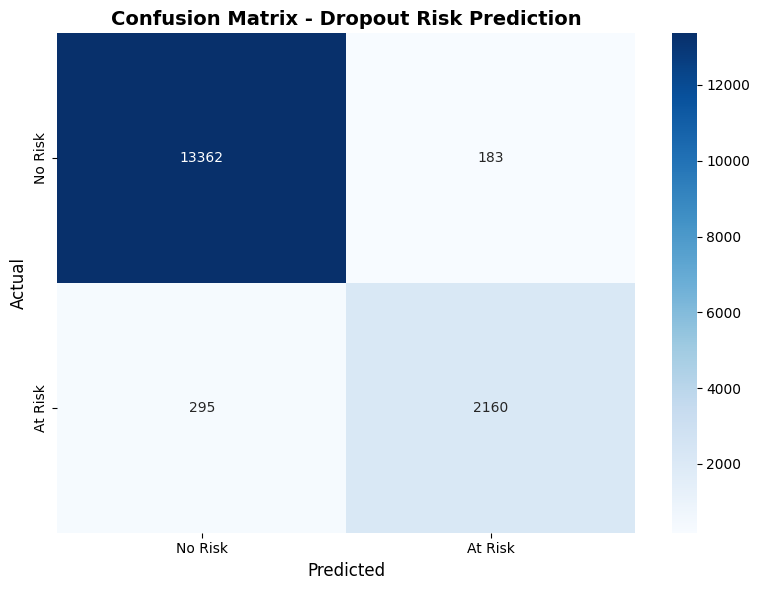

Saved: confusion_matrix.png


In [18]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'At Risk'],
            yticklabels=['No Risk', 'At Risk'])
plt.title('Confusion Matrix - Dropout Risk Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: confusion_matrix.png")



Generating Precision-Recall Curve...


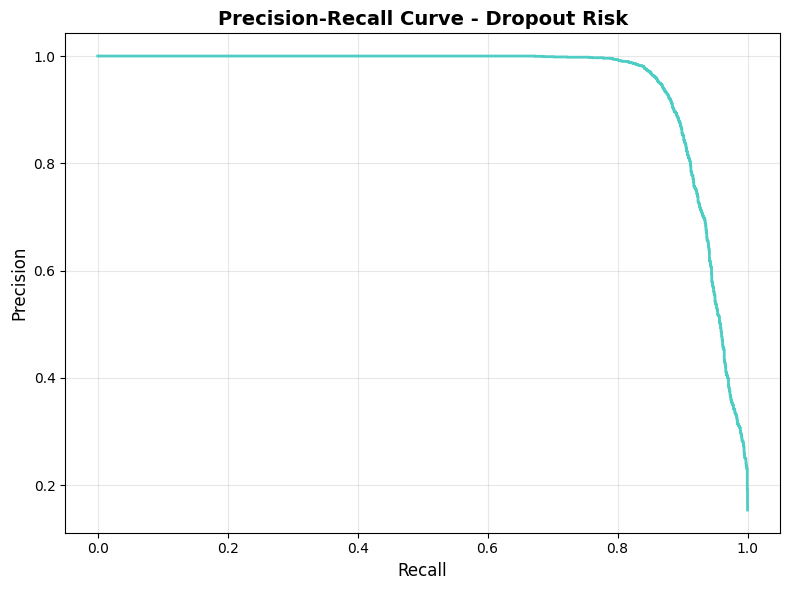

Saved: precision_recall_curve.png


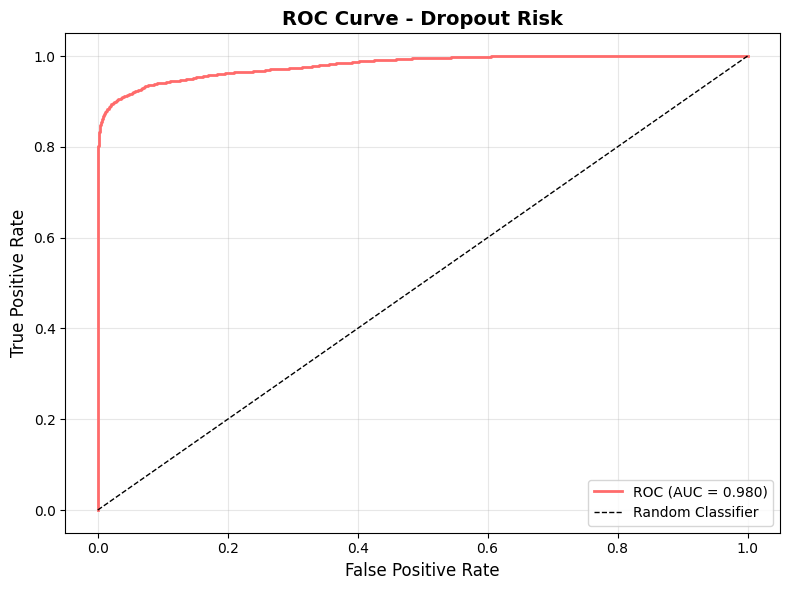

Saved: roc_curve.png


In [19]:
# Precision-Recall Curve
print("\nGenerating Precision-Recall Curve...")
precision_curve, recall_curve, thresholds = precision_recall_curve(
    y_test, y_pred_proba, pos_label='Yes'
)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, linewidth=2, color='#4ECDC4')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Dropout Risk', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: precision_recall_curve.png")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='Yes')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, color='#FF6B6B', label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Dropout Risk', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: roc_curve.png")

In [20]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc', n_jobs=-1)

print("Cross-Validation ROC-AUC Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation ROC-AUC Scores:
  Fold 1: 0.9810
  Fold 2: 0.9830
  Fold 3: 0.9847
  Fold 4: 0.9840
  Fold 5: 0.9874

Mean CV Score: 0.9840 (+/- 0.0042)



Top 20 Most Important Features:
               Feature  Importance
 attendance_percentage    0.215269
      motivation_level    0.115221
  mental_health_rating    0.089434
          stress_level    0.085673
   academic_engagement    0.085454
 time_management_score    0.056406
      study_efficiency    0.050413
   study_hours_per_day    0.033885
    exam_anxiety_score    0.026251
           screen_time    0.025463
  stress_support_ratio    0.024135
 study_to_social_ratio    0.021533
    total_distractions    0.019765
    social_media_hours    0.013759
     work_life_balance    0.012909
         netflix_hours    0.011839
            student_id    0.009123
         sleep_deficit    0.007621
           sleep_hours    0.007600
access_to_tutoring_Yes    0.006422


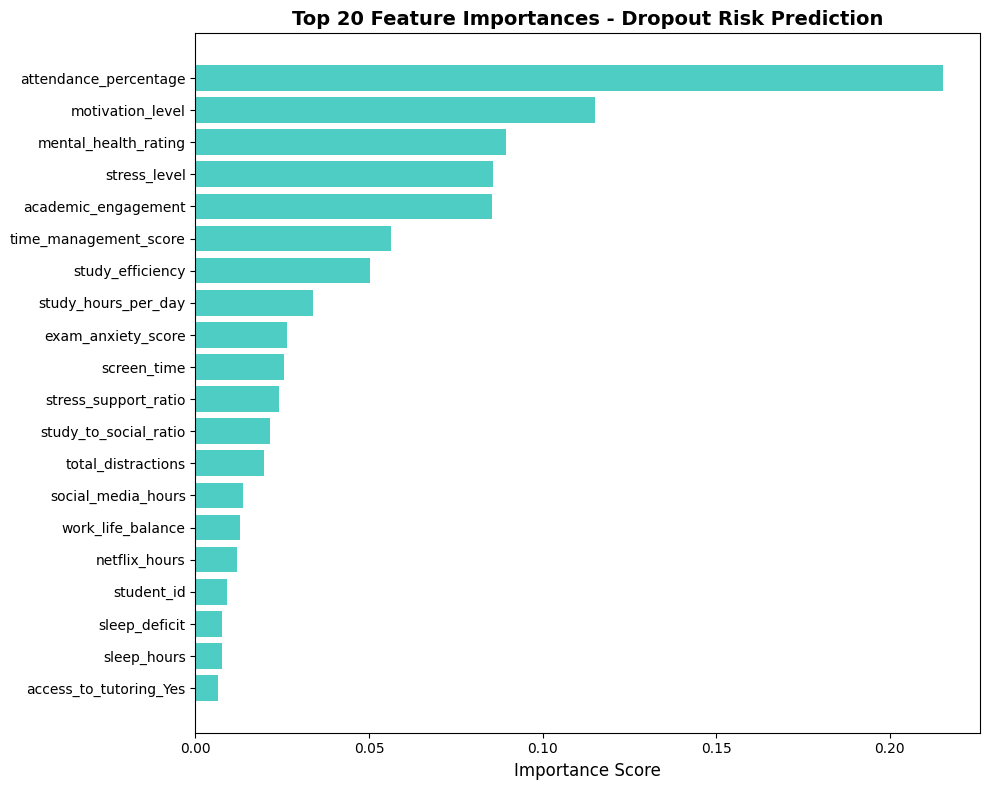

In [25]:
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='#4ECDC4')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Feature Importances - Dropout Risk Prediction',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [26]:
sample_idx = np.random.randint(0, len(X_test))
sample_student = X_test.iloc[sample_idx:sample_idx+1]
actual_risk = y_test.iloc[sample_idx]

predicted_risk = rf.predict(sample_student)[0]
predicted_proba = rf.predict_proba(sample_student)[0]

print(f"Sample Student #{sample_idx}")
print(f"\nActual Risk: {actual_risk}")
print(f"Predicted Risk: {predicted_risk}")
print(f"\nPrediction Probabilities:")
print(f"  No Risk: {predicted_proba[0]:.2%}")
print(f"  At Risk: {predicted_proba[1]:.2%}")

important_features = feature_importance.head(5)['Feature'].tolist()
print(f"\nKey Features for this student:")
for feat in important_features:
    if feat in sample_student.columns:
        print(f"  {feat}: {sample_student[feat].values[0]}")

Sample Student #14088

Actual Risk: No
Predicted Risk: No

Prediction Probabilities:
  No Risk: 61.62%
  At Risk: 38.38%

Key Features for this student:
  attendance_percentage: 41.5
  motivation_level: 5
  mental_health_rating: 4.2
  stress_level: 6.7
  academic_engagement: 3.569


In [27]:
# Save trained model and artifacts
print("SAVING MODELS AND ARTIFACTS")

import os
os.makedirs('models', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save essential artifacts
print("Saving models...")
joblib.dump(rf, f'models/rf_dropout_model_{timestamp}.pkl')
print(f"Saved: rf_dropout_model_{timestamp}.pkl")

joblib.dump(feature_columns, f'models/feature_columns_{timestamp}.pkl')
print(f"Saved: feature_columns_{timestamp}.pkl")

# Save optional artifacts (only if they exist)
if 'cluster_profile' in dir():
    joblib.dump(cluster_profile, f'models/cluster_profile_{timestamp}.pkl')
    print(f"Saved: cluster_profile_{timestamp}.pkl")
else:
    print("cluster_profile not found - skipping")

# Save metadata
metadata = {
    'timestamp': timestamp,
    'accuracy': accuracy,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'best_params': rf.get_params(),
    'features': feature_columns,
    'num_features': len(feature_columns)
}

import json
with open(f'models/model_metadata_{timestamp}.json', 'w') as f:
    json.dump(metadata, f, indent=4, default=str)
print(f"Saved: model_metadata_{timestamp}.json")

print(f"\nAll models saved with timestamp: {timestamp}")
logging.info("Model training and saving completed successfully!")
print("TRAINING COMPLETE!")


SAVING MODELS AND ARTIFACTS
Saving models...
Saved: rf_dropout_model_20260109_073702.pkl
Saved: feature_columns_20260109_073702.pkl
cluster_profile not found - skipping
Saved: model_metadata_20260109_073702.json

All models saved with timestamp: 20260109_073702
TRAINING COMPLETE!


In [31]:
# Save models - Works for STSSHR-MT-1 notebook
import joblib
import os
from sklearn.preprocessing import StandardScaler

os.makedirs('models', exist_ok=True)

# 1. Save Random Forest model (already trained)
joblib.dump(rf, 'models/rf_dropout_model.pkl')
print(" Random Forest model saved!")

# 2. Save feature columns
joblib.dump(feature_columns, 'models/feature_columns.pkl')
print(" Feature columns saved!")

# 3. Create and save scaler (fit on training data)
scaler = StandardScaler()

# Use the balanced training data if it exists
if 'X_train_balanced' in dir():
    scaler.fit(X_train_balanced)
    print(" Scaler fitted on X_train_balanced")
else:
    scaler.fit(X_train)
    print(" Scaler fitted on X_train")

joblib.dump(scaler, 'models/scaler.pkl')
print(" Scaler saved!")

print("SUCCESS! All models saved to 'models/' folder")

 Random Forest model saved!
 Feature columns saved!
 Scaler fitted on X_train_balanced
 Scaler saved!
SUCCESS! All models saved to 'models/' folder
